# Multi-modal RAG with LangChain

# Setup

Install the dependencies you need to run the notebook.

In [ ]:
!apt-get install poppler-utils tesseract-ocr libmagic-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
The following NEW packages will be installed:
  libmagic-dev poppler-utils
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 291 kB of archives.
After this operation, 1,086 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libmagic-dev amd64 1:5.41-3ubuntu0.1 [105 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.8 [186 kB]
Fetched 291 kB in 0s (1,293 kB/s)
Selecting previously unselected package libmagic-dev:amd64.
(Reading database ... 126102 files and directories currently installed.)
Preparing to unpack .../libmagic-dev_1%3a5.41-3ubuntu0.1_amd64.deb ...
Unpacking libmagic-dev:amd64 (1:5.41-3ubuntu0.1) ...
Selecting previously unselected package poppler-utils.
Preparing to unpack .../poppler

In [ ]:
%pip install -Uq "unstructured[all-docs]" pillow lxml
%pip install -Uq chromadb tiktoken
%pip install -Uq langchain langchain-community langchain-openai langchain-groq langsmith
%pip install -Uq python_dotenv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 14.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.5/112.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.1/526.1 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 45.2 MB/s eta 0:00:00
   ━

In [ ]:
import os
# keys
os.environ["GROQ_API_KEY"] = ""

In [ ]:
from google.colab import userdata
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

In [ ]:
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_API_KEY"]=userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_PROJECT"]="multimodal-rag-notebook"
os.environ["LANGCHAIN_ENDPOINT"]="https://api.smith.langchain.com"

In [ ]:
from langchain_openai import ChatOpenAI
#invoking llm model
llm = ChatOpenAI(model="gpt-4o-mini")
llm.invoke("Hello, world!")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 11, 'total_tokens': 20, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_54eb4bd693', 'id': 'chatcmpl-BZIg2TX7Q9jlfJmf6O9w2JTv6BrTS', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--024a531e-de3f-46ff-8ded-c4812d6ea5a8-0', usage_metadata={'input_tokens': 11, 'output_tokens': 9, 'total_tokens': 20, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

# Extract The Data

Extract the elements of the PDF that we will be able to use in the retrieval process.

## Partition PDF tables, text, and images

In [ ]:
from unstructured.partition.pdf import partition_pdf

output_path = "/content/"
file_path = output_path + 'attention.pdf'


#
chunks = partition_pdf(
    filename=file_path,
    infer_table_structure=True,            # extract tables
    strategy="hi_res",                     # mandatory to infer tables

    extract_image_block_types=["Image", "Table"],   # extract from of tables

    extract_image_block_to_payload=True,   #  extract base64

    chunking_strategy="by_title",
    max_characters=10000,                  # defaults to 500
    combine_text_under_n_chars=2000,       # defaults to 0
    new_after_n_chars=6000,
)

yolox_l0.05.onnx:   0%|          | 0.00/217M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/274 [00:00<?, ?B/s]

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [ ]:
set([str(type(el)) for el in chunks])#get types of elements from partition pdf

{"<class 'unstructured.documents.elements.CompositeElement'>"}

In [ ]:
chunks[3].metadata.orig_elements#CompositeElement containes a bunch of related element
#makes it easy to use these elements together in a RAG pipeline

In [ ]:
# This is what an extracted image looks like.
# It contains the base64 representation only because of the param extract_image_block_to_payload=True
elements = chunks[3].metadata.orig_elements
chunk_images = [el for el in elements if 'Image' in str(type(el))]
chunk_images[0].to_dict()

{'type': 'Image',
 'element_id': '42aa1bd1-26ff-47b3-845a-f2176c738047',
 'text': '',
 'metadata': {'coordinates': {'points': ((np.float64(486.0),
     np.float64(261.1805555555558)),
    (np.float64(486.0), np.float64(614.7805555555556)),
    (np.float64(664.0), np.float64(614.7805555555556)),
    (np.float64(664.0), np.float64(261.1805555555558))),
   'system': 'PixelSpace',
   'layout_width': 1700,
   'layout_height': 2200},
  'last_modified': '2025-05-20T14:52:37',
  'filetype': 'PPM',
  'languages': ['eng'],
  'page_number': 4,
  'image_base64': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAFiALIDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJ

## Separate extracted elements into tables, text, and images

In [ ]:
tables = [] # separate tables from texts
texts = []

for chunk in chunks:
    if "Table" in str(type(chunk)):
        tables.append(chunk)
    if "CompositeElement" in str(type((chunk))):
        texts.append(chunk)
        # extract tables from CompositeElement and add to tables list
        chunk_els = chunk.metadata.orig_elements
        for el in chunk_els:
            if "Table" in str(type(el)) and hasattr(el.metadata, 'text_as_html'):
                tables.append(el)

In [ ]:
len(tables)

4

In [ ]:
#look at data
texts[5].to_dict()

{'type': 'CompositeElement',
 'element_id': 'bc390b1d284d2d6186fec4f16873524e',
 'text': '3.3 Position-wise Feed-Forward Networks\n\nIn addition to attention sub-layers, each of the layers in our encoder and decoder contains a fully connected feed-forward network, which is applied to each position separately and identically. This consists of two linear transformations with a ReLU activation in between.\n\nFFN(x) = max(0,xW1 + b1)W2 + b2 (2)\n\nWhile the linear transformations are the same across different positions, they use different parameters from layer to layer. Another way of describing this is as two convolutions with kernel size 1. The dimensionality of input and output is dmodel = 512, and the inner-layer has dimensionality dff = 2048.\n\n3.4 Embeddings and Softmax\n\nSimilarly to other sequence transduction models, we use learned embeddings to convert the input tokens and output tokens to vectors of dimension dmodel. We also use the usual learned linear transfor- mation and so

## Check the table

In [ ]:
def get_tables_from_composite(chunks):
    tables = []
    for chunk in chunks:
        if "CompositeElement" in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if "Table" in str(type(el)) and hasattr(el.metadata, 'text_as_html'):
                    tables.append(el.metadata.text_as_html)
    return tables


tables_html = get_tables_from_composite(chunks)

In [ ]:
from IPython.display import display, HTML

def display_html_table(table_html):
    # display the HTML table
    display(HTML(table_html))


if tables_html:
    display_html_table(tables_html[0])
else:
    print("No tables found.")

Layer Type,Complexity per Layer,Sequential Operations,Maximum Path Length
Self-Attention,O(n? - d),O(1),O(1)
Recurrent,O(n - d?),O(n),O(n)
Convolutional,O(k-n-d?),O(1),O(logx(n))
Self-Attention (restricted),O(r-n-d),ol),O(n/r)


In [ ]:
display_html_table(tables_html[1])

## Check what the images look like

In [ ]:
# Get the images from the CompositeElement objects
def get_images_base64(chunks):
    images_b64 = []
    for chunk in chunks:
        if "CompositeElement" in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if "Image" in str(type(el)):
                    images_b64.append(el.metadata.image_base64)
    return images_b64

images = get_images_base64(chunks)

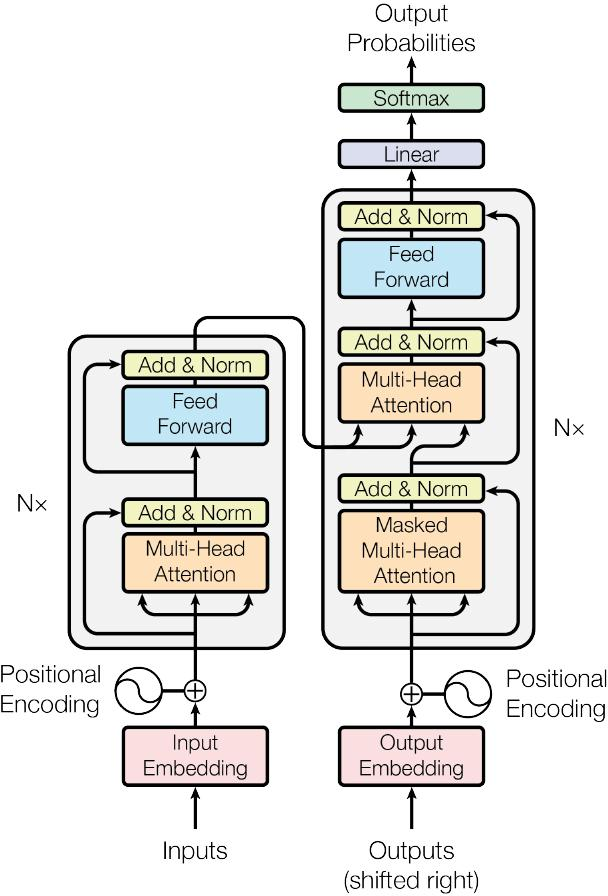

In [ ]:
import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    #decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    #display the image
    display(Image(data=image_data))

display_base64_image(images[0])

# Summarize the data

Create a summary of each element extracted from the PDF. This summary will be vectorized and used in the retrieval process.

In [ ]:
%pip install -u langchain-groq


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -u


## Text and Table summaries

In [ ]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

In [ ]:
# Prompt
prompt_text = """
You are an assistant tasked with summarizing tables and text.
Give a concise summary of the table or text.

Respond only with the summary, no additionnal comment.
Do not start your message by saying "Here is a summary" or anything like that.
Just give the summary as it is.

Table or text chunk: {element}

"""
prompt = ChatPromptTemplate.from_template(prompt_text)

#summary chain
model = ChatOpenAI(temperature=0.5, model="gpt-4o-mini")
# model = ChatGroq(temperature=0.5, model="llama3-70b-8192")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [ ]:
# Summarize text
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 3})

#Summarize tables
tables_html = [table.metadata.text_as_html for table in tables]
table_summaries = summarize_chain.batch(tables_html, {"max_concurrency": 3})

In [ ]:
text_summaries

['The paper introduces the Transformer, a new network architecture for sequence transduction that relies solely on attention mechanisms, eliminating the need for recurrent or convolutional networks. It demonstrates superior performance in machine translation tasks, achieving a BLEU score of 28.4 for English-to-German and a state-of-the-art score of 41.8 for English-to-French, with significantly reduced training time compared to existing models. The Transformer also shows strong generalization to other tasks, such as English constituency parsing. The authors contributed equally, with specific roles outlined for each member in the development of the model.',
 'Recurrent neural networks, particularly long short-term memory and gated recurrent networks, have been dominant in sequence modeling tasks like language modeling and machine translation. However, their sequential computation limits parallelization, especially with longer sequences. Recent advancements have improved efficiency but t

In [ ]:
table_summaries

['The table compares different layer types in terms of complexity, sequential operations, and maximum path length. Self-Attention has a complexity of O(n? - d), with O(1) sequential operations and a maximum path length of O(1). Recurrent layers have a complexity of O(n - d?), O(n) sequential operations, and a maximum path length of O(n). Convolutional layers show a complexity of O(k-n-d?), O(1) sequential operations, and a maximum path length of O(logx(n)). Restricted Self-Attention has a complexity of O(r-n-d), unspecified sequential operations, and a maximum path length of O(n/r).',
 'The table presents various models and their performance metrics in English-to-German (EN-DE) and English-to-French (EN-FR) translation tasks, along with their training parameters. Notable models include ByteNet with a score of 23.75, GNMT + RL achieving 24.6 (EN-DE) and 39.92 (EN-FR), and Transformer (big) reaching 28.4 (EN-DE) and 41.8 (EN-FR). Ensemble methods generally show improved performance, with

## Image summaries

In [ ]:
%pip install -Uq langchain_openai

In [ ]:
from langchain_openai import ChatOpenAI

prompt_template = """Describe the image in detail. For context,
                  the image is part of a research paper explaining the transformers
                  architecture. Be specific about graphs, such as bar plots."""
messages = [
    (
        "user",
        [
            {"type": "text", "text": prompt_template},
            {
                "type": "image_url",
                "image_url": {"url": "data:image/jpeg;base64,{image}"},
            },
        ],
    )
]

prompt = ChatPromptTemplate.from_messages(messages)

chain = prompt | ChatOpenAI(model="gpt-4o-mini") | StrOutputParser()


image_summaries = chain.batch(images)

In [ ]:
image_summaries

['The image illustrates the architecture of a Transformer model, commonly used in natural language processing tasks. Here’s a detailed description:\n\n1. **Overall Structure**: \n   - The diagram features two main sections, one representing the encoder and the other the decoder, labeled with "Nᵡ" to indicate multiple layers (stacks).\n\n2. **Encoder Section**:\n   - The encoder includes a series of blocks that contain several operations:\n     - **Multi-Head Attention**: This component allows the model to focus on different parts of the input sequence simultaneously.\n     - **Add & Norm**: This indicates a residual connection followed by layer normalization, helping stabilize training by preserving the input information.\n     - **Feed Forward**: A feed-forward network that processes each position independently.\n   - The encoder\'s output flows into the next layer or to the decoder, depending on the model\'s stage.\n\n3. **Decoder Section**:\n   - The decoder processes the output fro

In [ ]:
print(image_summaries[1])

The image presents a conceptual diagram of the Transformer architecture, focusing specifically on the attention mechanism. Here's a detailed description of its components:

1. **Boxes**: 
   - The diagram consists of several rectangular boxes connected by arrows, which indicate the flow of data through the various stages of the attention mechanism.

2. **MatMul (Matrix Multiplication)**:
   - There are three instances of boxes labeled "MatMul." This likely represents matrix multiplication operations, which are crucial in the attention mechanism for computing the interaction between different components (queries, keys, and values).

3. **SoftMax**:
   - Positioned above the second "MatMul" box, this light green box represents the SoftMax function. It typically converts the scores generated from the previous operations into probabilities.

4. **Mask (optional)**:
   - This element, shown as a pink box, indicates the application of a masking operation, which is optional. Masking is used t

# Load data and summaries to vectorstore

## Create the vectorstore

In [ ]:
import uuid
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers.multivector import MultiVectorRetriever

# The vectorstore to use to index the chunks
vectorstore = Chroma(collection_name="multi_modal_rag1", embedding_function=OpenAIEmbeddings())

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

<ipython-input-34-a27ec33527b9>:9: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  vectorstore = Chroma(collection_name="multi_modal_rag1", embedding_function=OpenAIEmbeddings())
<ipython-input-34-a27ec33527b9>:9: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(collection_name="multi_modal_rag1", embedding_function=OpenAIEmbeddings())


## Load the summaries and link the to the original data

In [ ]:
# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=summary, metadata={id_key: doc_ids[i]}) for i, summary in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# Add tables
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [
    Document(page_content=summary, metadata={id_key: table_ids[i]}) for i, summary in enumerate(table_summaries)
]
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))


# Add image summaries
img_ids = [str(uuid.uuid4()) for _ in images]
summary_img = [
    Document(page_content=summary, metadata={id_key: img_ids[i]}) for i, summary in enumerate(image_summaries)
]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(list(zip(img_ids, images)))

## Check Retrieval

In [ ]:
# Retrieve
docs = retriever.invoke(
    "who are the authors of the paper?"
)

In [ ]:
for doc in docs:
    print(str(doc) + "\n\n" + "-" * 80)

[36] Christian Szegedy, Vincent Vanhoucke, Sergey Ioffe, Jonathon Shlens, and Zbigniew Wojna. Rethinking the inception architecture for computer vision. CoRR, abs/1512.00567, 2015.

[37] Vinyals & Kaiser, Koo, Petrov, Sutskever, and Hinton. Grammar as a foreign language. In Advances in Neural Information Processing Systems, 2015.

[38] Yonghui Wu, Mike Schuster, Zhifeng Chen, Quoc V Le, Mohammad Norouzi, Wolfgang Macherey, Maxim Krikun, Yuan Cao, Qin Gao, Klaus Macherey, et al. Google’s neural machine translation system: Bridging the gap between human and machine translation. arXiv preprint arXiv:1609.08144, 2016.

[39] Jie Zhou, Ying Cao, Xuguang Wang, Peng Li, and Wei Xu. Deep recurrent models with fast-forward connections for neural machine translation. CoRR, abs/1606.04199, 2016.

[40] Muhua Zhu, Yue Zhang, Wenliang Chen, Min Zhang, and Jingbo Zhu. Fast and accurate shift-reduce constituent parsing. In Proceedings of the 51st Annual Meeting of the ACL (Volume 1: Long Papers), pages

In [ ]:
# Retrieve
docs = retriever.invoke(
    "What is the attention mechanism?"
)

In [ ]:
for doc in docs:
    print(str(doc) + "\n\n" + "-" * 80)

/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCATEBBYDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoo

# RAG pipeline

In [ ]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_openai import ChatOpenAI
from base64 import b64decode

def parse_docs(docs):
    """Split base64-encoded images, tables (HTML), and texts"""
    b64 = []
    text = []
    tables = []
    for doc in docs:
        try:
            b64decode(doc)
            b64.append(doc)
        except Exception:
            if isinstance(doc, str) and "<table" in doc:
                tables.append(doc)
            else:
                text.append(doc)
    return {"images": b64, "texts": text, "tables": tables}

def build_prompt(kwargs):

    docs_by_type = kwargs["context"]
    user_question = kwargs["question"]

    context_text = ""
    if len(docs_by_type["texts"]) > 0:
        for text_element in docs_by_type["texts"]:
            context_text += text_element.text

    # construct prompt with context (including images)
    prompt_template = f"""
    Answer the question based only on the following context, which can include text, table and the below image.
    Context: {context_text}
    Question: {user_question}
    """

    prompt_content = [{"type": "text", "text": prompt_template}]

    if len(docs_by_type["images"]) > 0:
        for image in docs_by_type["images"]:
            prompt_content.append(
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image}"},
                }
            )

    return ChatPromptTemplate.from_messages(
        [
            HumanMessage(content=prompt_content),
        ]
    )


chain = (
    {
        "context": retriever | RunnableLambda(parse_docs),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt)
    | ChatOpenAI(model="gpt-4o-mini")
    | StrOutputParser()
)

chain_with_sources = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response=(
        RunnableLambda(build_prompt)
        | ChatOpenAI(model="gpt-4o-mini")
        | StrOutputParser()
    )
)

## Question 1

Response: Transformer architecture is a model designed for processing sequential data, such as natural language. It consists of an encoder-decoder structure, where both the encoder and decoder each have multiple layers (Nx in the diagram). 

Key components include:

1. **Multi-Head Attention:** This allows the model to focus on different parts of the input sequence simultaneously, enhancing its understanding of relationships within the data.

2. **Feed Forward Networks:** Each layer contains a feed-forward neural network that processes the output of the attention mechanism.

3. **Add & Norm:** This involves adding the input of a layer to its output (residual connection) and normalizing the results to stabilize training.

4. **Positional Encoding:** Since transformers do not inherently understand the order of sequences, positional encodings are added to input embeddings to provide information about the position of each element in the sequence.

5. **Output Probabilities:** After passing

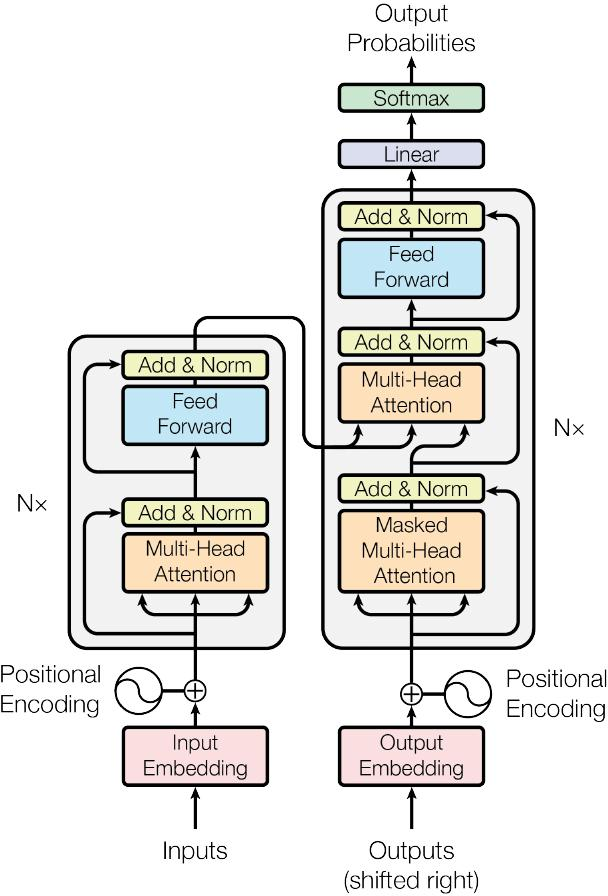

In [ ]:
response = chain_with_sources.invoke(
    "What is transformer architecture?"
)

print("Response:", response['response'])

print("\n\nContext:")
for text in response['context']['texts']:
    print(text.text)
    print("Page number: ", text.metadata.page_number)
    print("\n" + "-"*50 + "\n")
for image in response['context']['images']:
    display_base64_image(image)

## Question 2

Response: In the context of the diagram provided, k, q, and v refer to the following:

- **K**: Keys
- **Q**: Queries
- **V**: Values 

These are components used in the Scaled Dot-Product Attention mechanism within neural network architectures, specifically in the context of tasks like natural language processing.


Context:


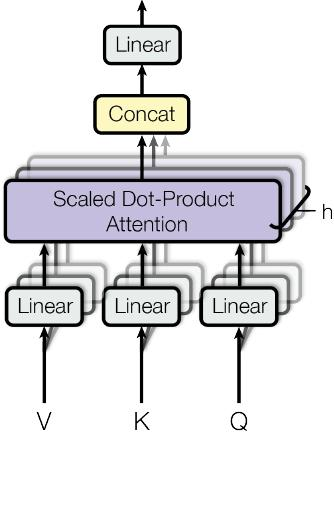

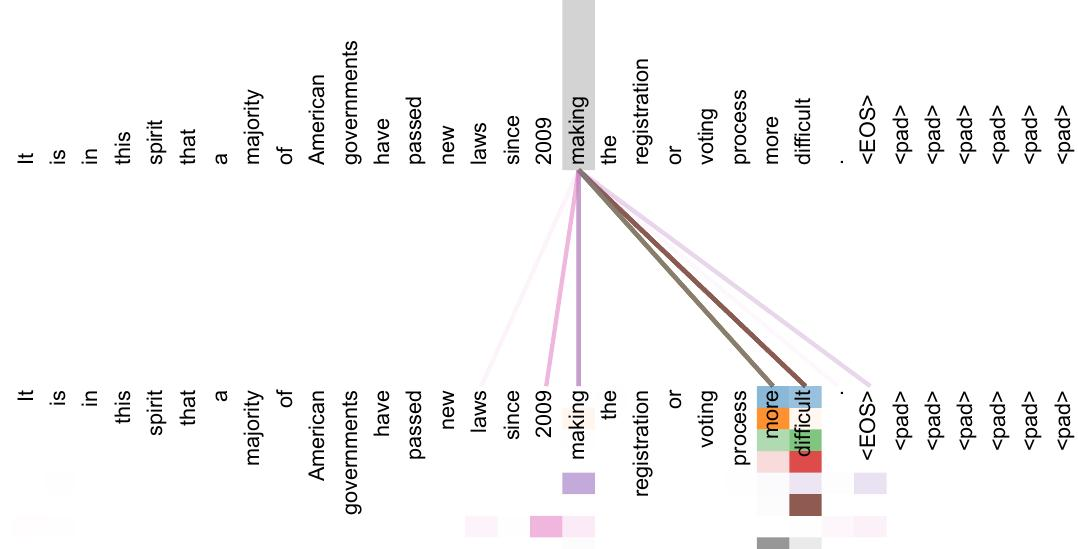

In [ ]:
response = chain_with_sources.invoke(
    "What is k, q, and v?"
)

print("Response:", response['response'])

print("\n\nContext:")
for text in response['context']['texts']:
    print(text.text)
    print("Page number: ", text.metadata.page_number)
    print("\n" + "-"*50 + "\n")
for image in response['context']['images']:
    display_base64_image(image)

## Question 3

Response: Scaled dot-product attention is a mechanism used in neural networks, particularly in transformer models, to compute attention scores between different inputs. It involves the following key steps:

1. **Inputs**: It takes three matrices as inputs—queries (Q), keys (K), and values (V).
2. **Dot Product**: It computes the dot product of the queries and keys to obtain attention scores.
3. **Scaling**: The scores are scaled by dividing them by the square root of the dimension of the key vectors to prevent excessively large values that could affect the gradient during training.
4. **Softmax**: A softmax function is applied to the scaled scores to obtain the attention weights, which indicate the relevance of each key to the corresponding query.
5. **Weighted Sum**: Finally, the attention weights are used to compute a weighted sum of the values (V), producing the final output.

This process allows the model to focus on different parts of the input data, improving its ability to handl

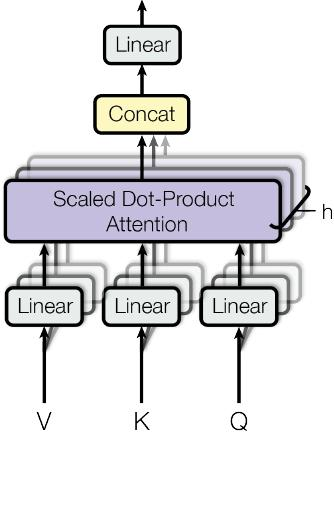

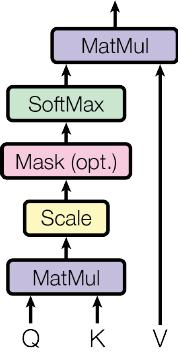

In [ ]:
response = chain_with_sources.invoke(
    "What is scaled dot product attention?"
)

print("Response:", response['response'])

print("\n\nContext:")
for text in response['context']['texts']:
    print(text.text)
    print("Page number: ", text.metadata.page_number)
    print("\n" + "-"*50 + "\n")
for image in response['context']['images']:
    display_base64_image(image)

## Question 4

In [ ]:
response = chain_with_sources.invoke(
    "What is BLEU score of ByteNet model and ConvS2S model?"
)

print("Response:", response['response'])

print("\n\nContext:")
for text in response['context']['texts']:
    print(text.text)
    print("Page number: ", text.metadata.page_number)
    print("\n" + "-"*50 + "\n")
for image in response['context']['images']:
    display_base64_image(image)
for table_html in response['context']['tables']:
  display_html_table(table_html)

Response: The BLEU score of the ByteNet model is 23.75, and the BLEU score of the ConvS2S model is 25.16.


Context:
Model BLEU EN-DE EN-FR Training Cost (FLOPs) EN-DE EN-FR ByteNet [18] 23.75 Deep-Att + PosUnk [39] 39.2 1.0 · 1020 GNMT + RL [38] 24.6 39.92 2.3 · 1019 1.4 · 1020 ConvS2S [9] 25.16 40.46 9.6 · 1018 1.5 · 1020 MoE [32] 26.03 40.56 2.0 · 1019 1.2 · 1020 Deep-Att + PosUnk Ensemble [39] 40.4 8.0 · 1020 GNMT + RL Ensemble [38] 26.30 41.16 1.8 · 1020 1.1 · 1021 ConvS2S Ensemble [9] 26.36 41.29 7.7 · 1019 1.2 · 1021 Transformer (base model) 27.3 38.1 3.3 · 1018 Transformer (big) 28.4 41.8 2.3 · 1019
Page number:  8

--------------------------------------------------

6 Results

6.1 Machine Translation

On the WMT 2014 English-to-German translation task, the big transformer model (Transformer (big) in Table 2) outperforms the best previously reported models (including ensembles) by more than 2.0 BLEU, establishing a new state-of-the-art BLEU score of 28.4. The configuration of t

## Question 5

In [ ]:
response = chain_with_sources.invoke(
    "Which parser has the highest score? Also mention the score."
)

print("Response:", response['response'])

print("\n\nContext:")
for text in response['context']['texts']:
    print(text.text)
    print("Page number: ", getattr(text.metadata, 'page_number', 'N/A'))
    print("\n" + "-"*50 + "\n")
for image in response['context']['images']:
    display_base64_image(image)


Response: The parser with the highest score is the Dyer et al. (2016) [8] generative parser, which has a score of 93.3.


Context:
Parser Training WSJ 23 F1 Vinyals & Kaiser el al. (2014) [37] WSJ only, discriminative 88.3 Petrov et al. (2006) [29] WSJ only, discriminative 90.4 Zhu et al. (2013) [40] WSJ only, discriminative 90.4 Dyer et al. (2016) [8] WSJ only, discriminative 91.7 Transformer (4 layers) WSJ only, discriminative 91.3 Zhu et al. (2013) [40] semi-supervised 91.3 Huang & Harper (2009) [14] semi-supervised 91.3 McClosky et al. (2006) [26] semi-supervised 92.1 Vinyals & Kaiser el al. (2014) [37] semi-supervised 92.1 Transformer (4 layers) semi-supervised 92.7 Luong et al. (2015) [23] multi-task 93.0 Dyer et al. (2016) [8] generative 93.3
Page number:  10

--------------------------------------------------

big

6

1024

4096

16

0.3

300K 4.33

26.4

development set, newstest2013. We used beam search as described in the previous section, but no checkpoint averaging. We pre

# Langsmith vector store and one question answer